# **Análisis de componentes principales**

Este caso práctico muestra un ejemplo de cómo hacer un análisis de componentes principales en R
La meta del caso es conocer una de las funciones más usadas en R para hacer análisis de componentes principales. Entender las salidas que ofrece y tomar decisiones de análisis basadas en ellas.

**Contexto: ** 
El sector de los bienes raíces es uno de los más exitosos en la economía del mundo. La gran mayoría de personas en el mundo deciden rentar sus viviendas por comodidad o economía.


**Problema de negocio:** Existen relaciones fuertes entre las variables a considerar cuando se busca un inmueble para rentarlo? Si es así cómo podría resumir esta información para lograr encontrar un lugar de renta


Empezaremos por cargar las librerías requeridas para este caso

In [1]:
library(factoextra)
library(ggcorrplot)
library(repr)

Loading required package: ggplot2

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



Definimos nuestra ruta de trabajo, dónde tenemos guardados nuestros datos

In [2]:
#setwd('C:/Users/Juliana/Desktop/Diplomado/D_2020/Casos') 
setwd('/root/Documentos/UN/UN_2020_2/DCD/module_4/class_2/jupyter/data')

### **Datos**
Vamos a utilizar una tabla de datos que contiene información sobre los inmuebles en renta y sus características en el mercado de Brasil. La documentación de los mismos puede encontrarse en https://www.kaggle.com/rubenssjr/brasilian-houses-to-rent?select=houses_to_rent_v2.csv
Así pues, para cada inmueble se tiene la siguiente información:

- **city:** ciudad donde la propiedad esta ubicada
- **area:** area de la propiedad
- **rooms:** número de cuartos
- **bathroom:** número de baños 
- **parking spaces:** número de parqueaderos
- **floor:** piso 
- **animal:** acepta animales - Categórica
- **furnished:** esta amoblada - Categórica
- **hoa:** administración
- **rent amount:** renta
- **property tax:** impuesto predial 
- **fire insurance:** seguro de incendio
- **total:** valor total - $total= rent amount + property tax + fire insurance$

In [3]:
data <- read.csv('houses_to_rent_v2.csv',header=T)
head(data)

,city,area,rooms,bathroom,parking.spaces,floor,animal,furniture,hoa,rent,property_tax,fire_insurance,total
,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>
1,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
2,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
3,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
4,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
5,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836
6,São Paulo,376,3,3,7,-,acept,not furnished,0,8000,834,121,8955


## **Pre-procesamiento y Limpieza**

Debemos modificar la variable **floor** ya que sería interesante incluirla como un valor numérico. Sin embargo el tipo de variable es un factor y contiene el valor '-' para referirse al ground floor.

In [4]:
class(data$floor)
levels(data$floor)[1]<-0 # modificar - por el 0 como ground floor
data$floor <- as.numeric(as.character(data$floor))

[1] "factor"

Queremos hacer un análisis por componentes principales en datos sobre inmuebles rentados. Para acotar nuestro análisis filtraremos únicamente los registros de Sao Paulo. Adicionalmente, para ésta técnica únicamente requerimos de las variables numéricas, por lo cual excluimos del análisis las variables **animal** y **furnished**.

In [5]:
# São Paulo
data_acp <- data[data$city=='São Paulo',c('area','rooms','bathroom','parking.spaces','floor','hoa','rent','property_tax',
                                           'fire_insurance','total')]

## Exploración

Empecemos haciendo una exploración de los datos 

In [6]:
summary(data_acp)

      area             rooms           bathroom      parking.spaces  
 Min.   :   11.0   Min.   : 1.000   Min.   : 1.000   Min.   : 0.000  
 1st Qu.:   59.0   1st Qu.: 2.000   1st Qu.: 1.000   1st Qu.: 1.000  
 Median :  106.0   Median : 3.000   Median : 2.000   Median : 1.000  
 Mean   :  158.9   Mean   : 2.559   Mean   : 2.468   Mean   : 1.878  
 3rd Qu.:  212.0   3rd Qu.: 3.000   3rd Qu.: 4.000   3rd Qu.: 3.000  
 Max.   :24606.0   Max.   :10.000   Max.   :10.000   Max.   :12.000  
     floor             hoa              rent        property_tax     
 Min.   : 0.000   Min.   :     0   Min.   :  500   Min.   :     0.0  
 1st Qu.: 0.000   1st Qu.:     0   1st Qu.: 2000   1st Qu.:    37.0  
 Median : 4.000   Median :   665   Median : 3400   Median :   170.0  
 Mean   : 5.626   Mean   :  1170   Mean   : 4653   Mean   :   495.7  
 3rd Qu.: 9.000   3rd Qu.:  1608   3rd Qu.: 6000   3rd Qu.:   550.0  
 Max.   :46.000   Max.   :220000   Max.   :45000   Max.   :313700.0  
 fire_insurance     

Podemos revisar la correlación entre las variables numéricas 

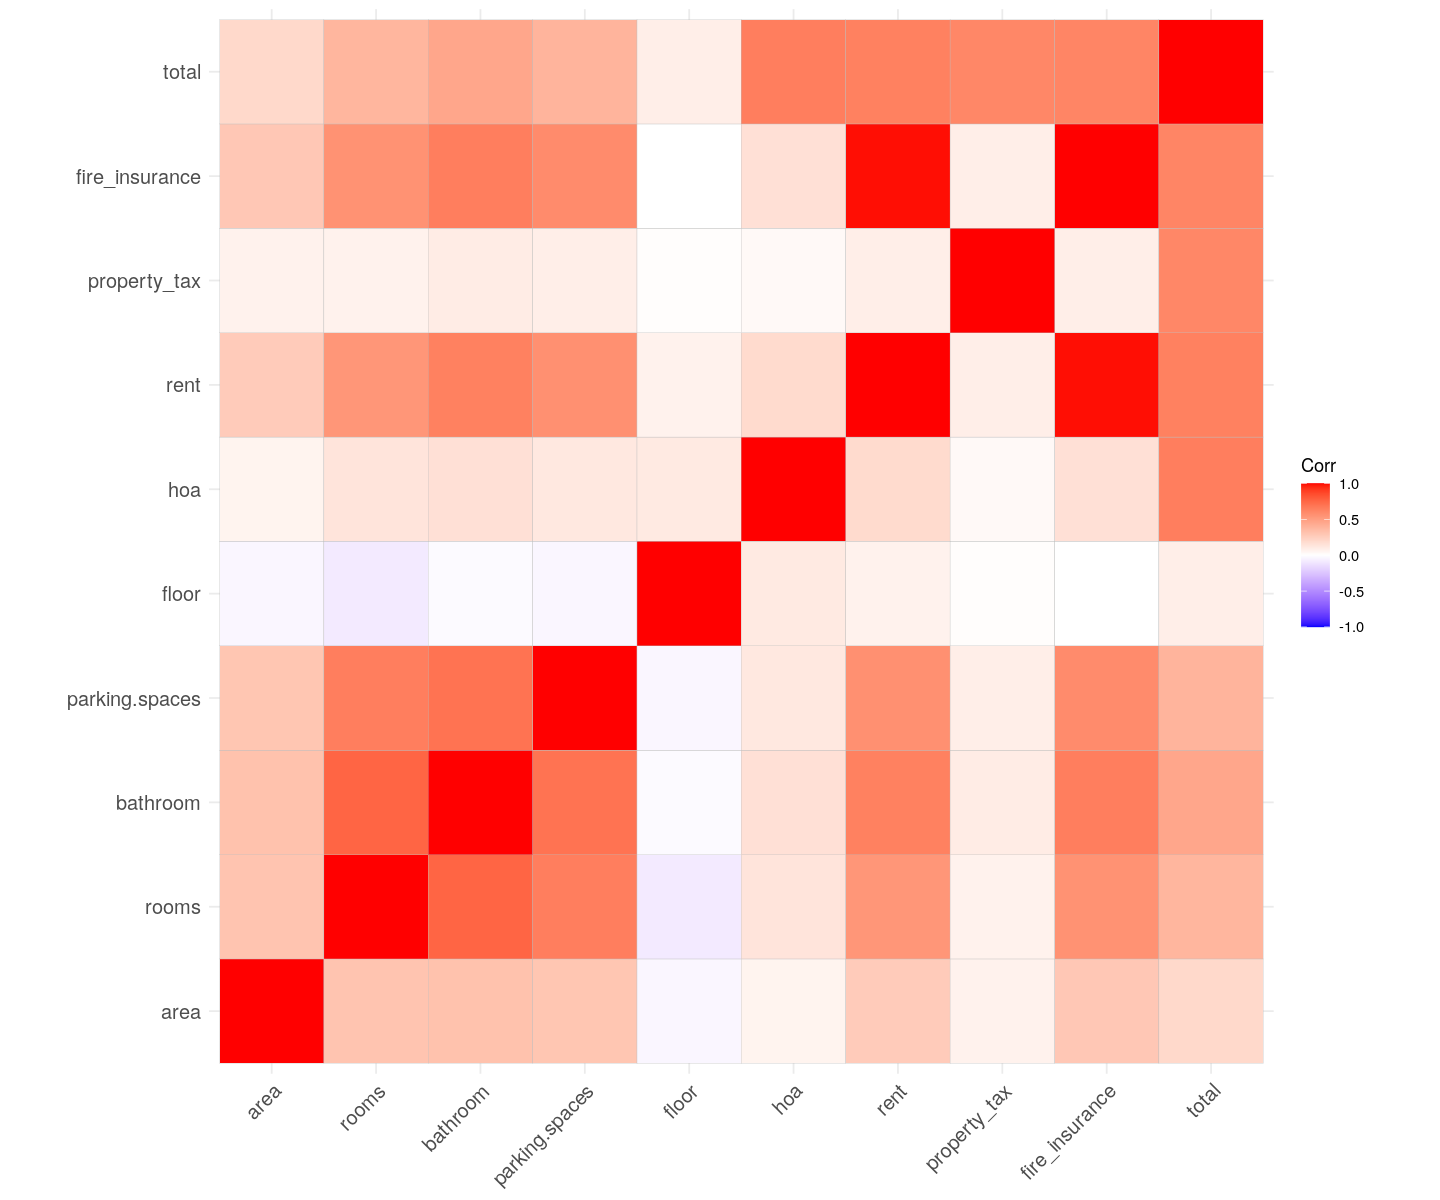

In [7]:
options(repr.plot.width = 12, repr.plot.height=10)
ggcorrplot(round(cor(data_acp),2))

De lo anetior ya podemos entender el funcionamiento de los datos. Aquí podemos tomar la decisión de sacar información que se vuelve redundante. En particular, la variable **total** resulta ser la suma de **hoa**, **rent**,**property_tax** y **fire_insurance**. Podemos observar la relación lineal casi perfecta entre el costo total y el seguro contra incendios, probablemente se calcula de acuerdo al canon de arrendamiento. En este punto podemos quedarnos únicamente con las variables **hoa** y **rent** las cuales contienen suficiente información para entender los costos. 

In [8]:
data_acp = data_acp[,c('area','rooms','bathroom','parking.spaces','floor','hoa','rent')]

El análisis de componentes principales es sensible a las dimensiones. Es recomendable siempre hacer una estandarización de las variables a utilizar para que las unidades de análisis no interfieran en el análisis. La idea es llevar todas las variables a la misma escala, así esta no interfiere con los resultados del análisis. Esto lo podemos hacer transformando a las variables para que tengan media cero y varianza 1.  Hagamos la estandarización del valor de la renta:

In [9]:
# calculamos la media de la variable
media_renta <- mean(data_acp$rent)
# Calculamos la desviación estándar
ds_renta <- sd(data_acp$rent)
# a cada valor restamos la media y dividimos por la desviación estándar
data_acp$renta_std1 <- (data_acp$rent - media_renta)/(ds_renta)
# Revisemos el resultado
head(data_acp[,c('rent','renta_std1')])
summary(data_acp[,c('rent','renta_std1')])

,rent,renta_std1
,<int>,<dbl>
1,3300,-0.37219758
2,4960,0.08452242
5,800,-1.06002890
6,8000,0.92092532
8,3223,-0.39338278
9,15000,2.84685303


      rent         renta_std1     
 Min.   :  500   Min.   :-1.1426  
 1st Qu.: 2000   1st Qu.:-0.7299  
 Median : 3400   Median :-0.3447  
 Mean   : 4653   Mean   : 0.0000  
 3rd Qu.: 6000   3rd Qu.: 0.3707  
 Max.   :45000   Max.   :11.1008  

Existe también una función **scale** que hace éste cómputo por nosotros

In [10]:
data_acp$renta_std2 <- scale(data_acp$rent)
head(data_acp[,c('rent','renta_std1','renta_std2')])
summary(data_acp[,c('rent','renta_std1','renta_std2')])

,rent,renta_std1,renta_std2
,<int>,<dbl>,"<dbl[,1]>"
1,3300,-0.37219758,-0.37219758
2,4960,0.08452242,0.08452242
5,800,-1.06002890,-1.06002890
6,8000,0.92092532,0.92092532
8,3223,-0.39338278,-0.39338278
9,15000,2.84685303,2.84685303


      rent         renta_std1         renta_std2.V1   
 Min.   :  500   Min.   :-1.1426   Min.   :-1.142569  
 1st Qu.: 2000   1st Qu.:-0.7299   1st Qu.:-0.729870  
 Median : 3400   Median :-0.3447   Median :-0.344684  
 Mean   : 4653   Mean   : 0.0000   Mean   : 0.000000  
 3rd Qu.: 6000   3rd Qu.: 0.3707   3rd Qu.: 0.370660  
 Max.   :45000   Max.   :11.1008   Max.   :11.100829  

Eliminamos estas dos columnas creadas 

In [11]:
data_acp <- data_acp[,c('area','rooms','bathroom','parking.spaces','floor','hoa','rent')]

## **Análisis de componentes principales**

La gran mayoría de implementaciones en R o Python de ACP tienen la posibilidad de estandarizar las variables dentro de la función. En este caso utilizaremos la función **prcomp** del paquete **factoextra**, dónde encontramos el argumentos **scale** que debe ponerse como TRUE para estandarizar las variables del análisis

In [12]:
## Ajustamos el pca, utulizamos la opcion scale=TRUE 
# El True indica que se desea estandarizar las varibes
pca_renta <- prcomp(data_acp,scale=TRUE)
summary(pca_renta)

Importance of components:
                         PC1    PC2    PC3    PC4     PC5     PC6     PC7
Standard deviation     1.775 1.0590 0.9311 0.9073 0.67944 0.59830 0.46801
Proportion of Variance 0.450 0.1602 0.1239 0.1176 0.06595 0.05114 0.03129
Cumulative Proportion  0.450 0.6102 0.7340 0.8516 0.91757 0.96871 1.00000

Revisemos el objeto del ACP con la función names() para saber qué información nos da

In [13]:
names(pca_renta)

[1] "sdev"     "rotation" "center"   "scale"    "x"

De lo anterior podemos observar alguna de la información más relevante 

- Los elementos center y scale almacenados en el objeto pca contienen la media y desviación típica de las variables previa estandarización
- El elemento sdev contiene la desviación estándar de cada CP
- La relación entre las variables originales y los componentes principales ($rotation) (vectores propios)
- Los valores de cada $x en términos de los componentes principales

In [14]:
pca_renta$center #medias variables originales
pca_renta$scale #Desviasiones variables originales
pca_renta$sdev # Desvisión estandar de cada componente principal

area          rooms       bathroom parking.spaces          floor 
    158.899439       2.558859       2.467641       1.877527       5.626465 
           hoa           rent 
   1169.627994    4652.793783

area          rooms       bathroom parking.spaces          floor 
    347.474169       1.166365       1.503060       1.687973       6.056361 
           hoa           rent 
   4076.461180    3634.612007

[1] 1.7747860 1.0589549 0.9310854 0.9073036 0.6794391 0.5982972 0.4680088

Y podemos describir entonces cómo está hecha la combinación lineal de cada variable original para definir los componentes principales

In [15]:
pca_renta$rotation # Indica el peso de cada variable sobre el PCx

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
area,0.26990385,-0.14308109,0.16720584,-0.937380676,0.004042948,0.0001332592,0.004798586
rooms,0.47990926,-0.11104172,-0.02921644,0.148963377,0.442807042,-0.4896125310,-0.546364936
bathroom,0.50658877,-0.01680270,0.03610733,0.159677236,0.165789783,-0.2016573462,0.805067074
parking.spaces,0.47351131,-0.06517973,0.06586929,0.158010808,0.151138557,0.8337170096,-0.155902373
floor,-0.01713239,0.76018954,0.62187436,-0.009472766,0.181462293,-0.0188220947,-0.041449379
hoa,0.13939036,0.60537878,-0.75656417,-0.186960690,0.064311879,0.0508560042,-0.004567914
rent,0.44302447,0.13525977,0.08018127,0.116700957,-0.846470248,-0.1469326714,-0.165181322


Por ejemplo, la primer componente se puede definir así:

$PC1= 0.26area+0.47rooms+0.50bathroom+0.47parking-0.017floor+0.13hoa+0.44rent$

Estos pesos de cada variable en el primer componente nos dan una idea de qué información está recogiendo la dimensión.


Finalmente el objeto de $x nos muestra cómo está representada cada observación en las nuevas dimensiones

In [16]:
head(pca_renta$x) # Coordenada para cada componente según el PCx

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
1,-1.1779772,0.3951331,-0.15326194,-0.1562598,-0.08332466,0.05963177,-0.39340985
2,0.7057070,1.6719278,1.48199972,-0.2775199,0.90950737,-1.79453523,0.20894816
5,-2.2632730,-0.6053354,-0.47687770,-0.2323670,-0.18315695,0.07942469,0.32375789
6,2.3504457,-1.0905080,0.01928488,0.1766541,-0.27918726,2.14113131,-0.50392295
8,1.6142545,-0.3548922,-0.29023166,0.3064866,1.20818106,0.31418263,0.02529063
9,0.6237723,0.1253611,-0.04474095,0.1595309,-2.83355054,-0.54834019,-0.35981653


Paso seguido podemos visualizar los valores propios para saber qué tan buena es la reducción en los componentes principales

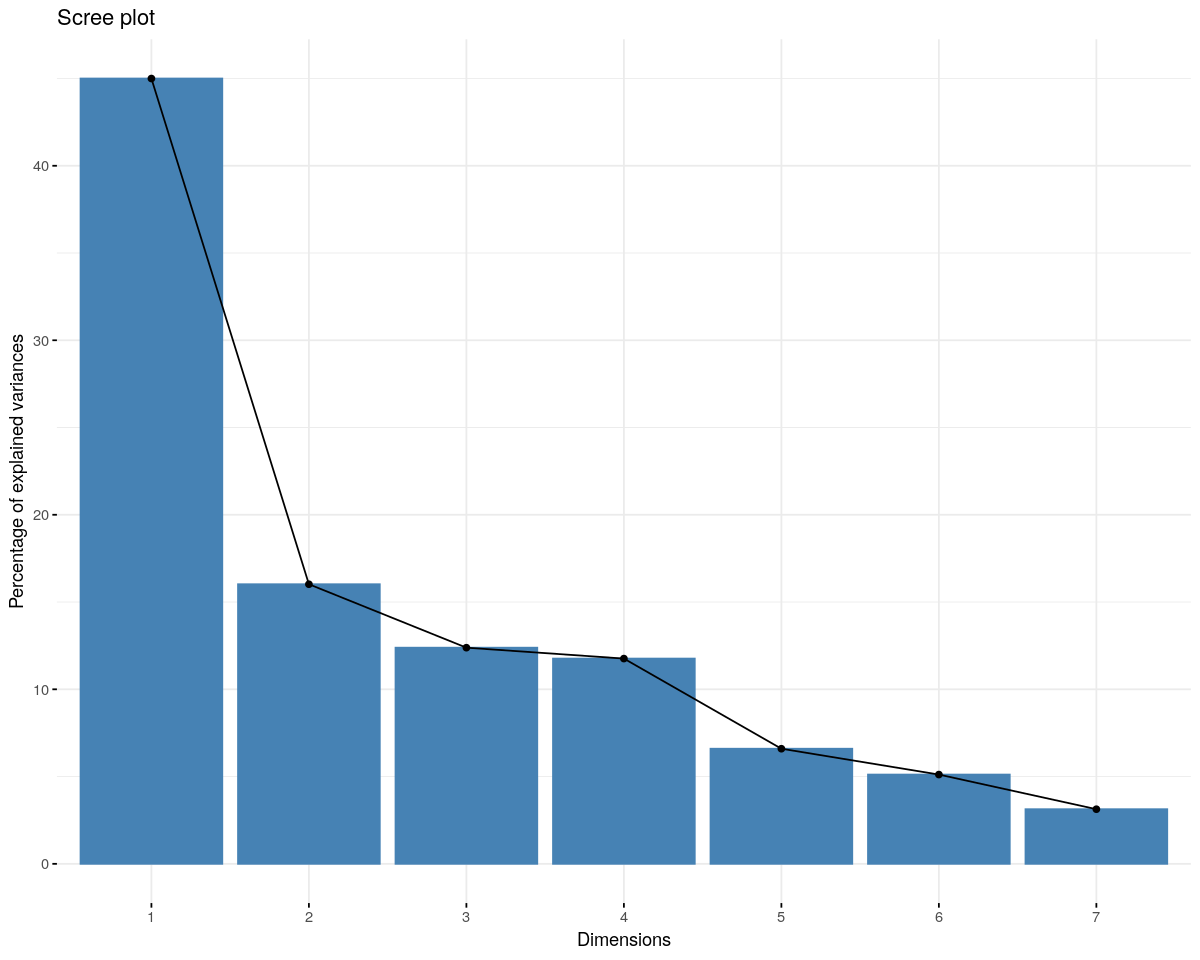

In [39]:
# revisamos los valores propios
options(repr.plot.width = 10, repr.plot.height=8)
fviz_eig(pca_renta)

También podemos hacer una visualización de las variables originales en las nuevas dimensiones. Primero revisemos las dos primeras componentes

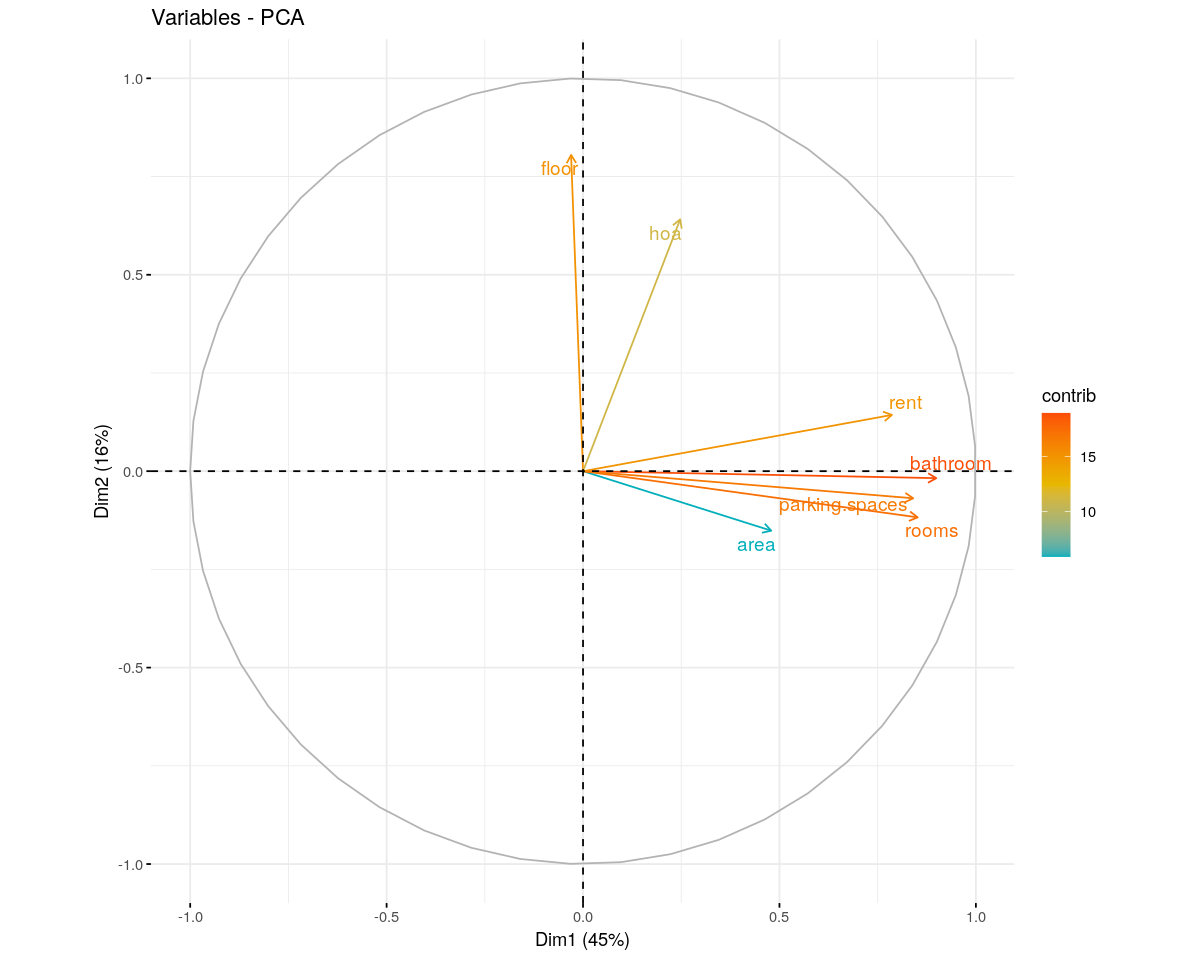

In [40]:
fviz_pca_var(pca_renta,axes = c(1, 2),
             col.var = "contrib", # Color by contributions to the PC
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
             repel = TRUE     # Avoid text overlapping
)

La cercanía al circulo unitario es un indicativo de qué tan buena es ésta representación para cada variable

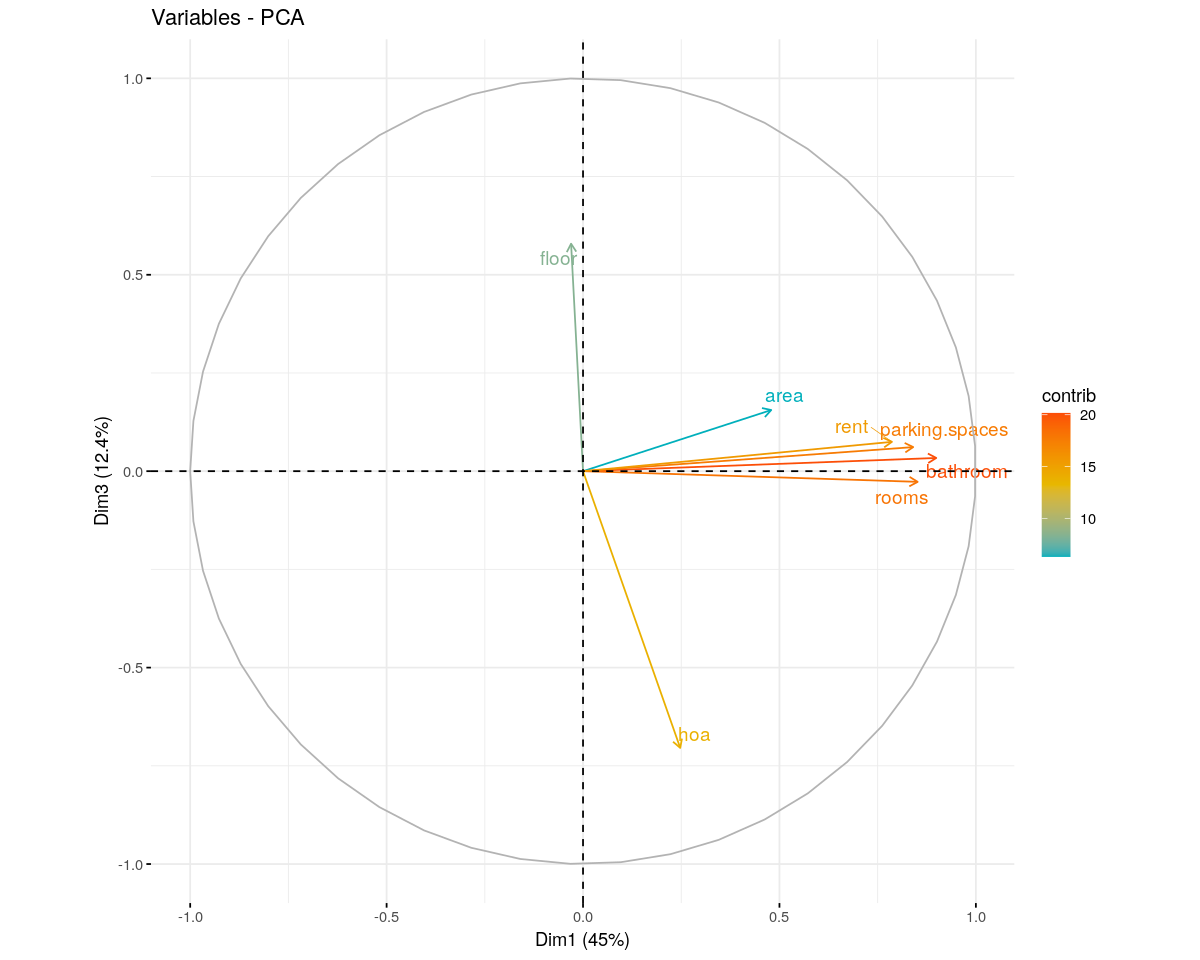

In [41]:
fviz_pca_var(pca_renta,axes = c(1, 3),
             col.var = "contrib", # Color by contributions to the PC
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
             repel = TRUE     # Avoid text overlapping
)

Podemos también visualizar los individuos en el mismo plano. Dado que tenemos 5887 observaciones la siguiente función puede tomar mucho tiempo para graficar los resultados. Por esta razón, sólo graficaremos las primeras 150 observaciones

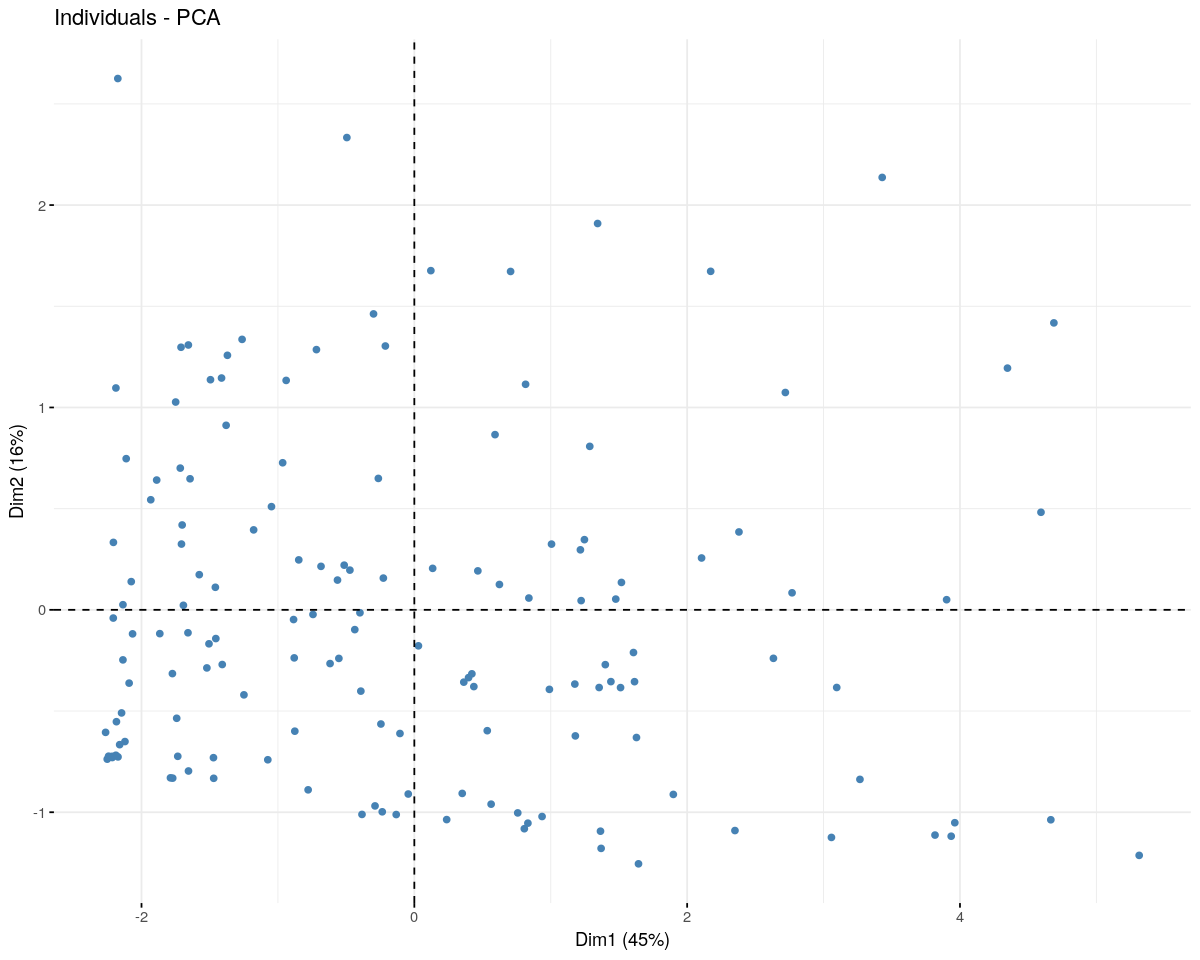

In [42]:
fviz_pca_ind(pca_renta, select.ind = list(name = rownames(data_acp)[1:150]),col.ind = 'steelblue',geom='point')

## **Ejercicios**

**1. ¿Qué conclusiones podríamos sacar del biplot de la primer y segunda componente?**

**2. Ajustemos el mismo análisis para la ciudad de Rio de Janeiro, ¿qué resultados se obtienen? ¿hay diferencias con el análisis anterior?**

## **Conclusiones**

- El análisis de componentes principales resulta ser una gran herramienta para resumir información 

- Se pueden visualizar y encontrar patrones de forma multivariada

- Es posible identificar también información recurrente